# Insight for Customer Profiling

In [2]:
# importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
# importing data set
path = r'C:\Users\nvak6\12-12-2024 Instacart Basket Analysis'
merged_data = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'merged_data.pkl'))

## Security Check

What were checking for: **Personally Identifiable Information (PII)** - Data that can be tracked back to a particular person  

    Ex. names, email addresses, physical addresses, and phone numbers, etc.

        PII information within our data include: First name and Last name (surname)

In [5]:
# Creating a data set reomving PII information
clean_data = merged_data.drop(columns = ['First Name', 'Surnam','add_to_cart_order','reordered','order_number'])

## Customer Regions

In [7]:
# Define regions as lists
northeast_states = ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut", 
                    "New York", "Pennsylvania", "New Jersey"]
midwest_states = ["Wisconsin", "Michigan", "Illinois", "Indiana", "Ohio", "North Dakota", "South Dakota", 
                  "Nebraska", "Kansas", "Minnesota", "Iowa", "Missouri"]
south_states = ["Delaware", "Maryland", "District of Columbia", "Virginia", "West Virginia", "North Carolina", 
                "South Carolina", "Georgia", "Florida", "Kentucky", "Tennessee", "Mississippi", "Alabama", 
                "Oklahoma", "Texas", "Arkansas", "Louisiana"]
west_states = ["Idaho", "Montana", "Nevada", "Wyoming", "Utah", "Colorado", "Arizona", "New Mexico", 
               "Alaska", "Washington", "Oregon", "California", "Hawaii"]

In [8]:
# Define a function to assign a region based on the state
def get_region(state):
    if state in northeast_states:
        return "Northeast"
    elif state in midwest_states:
        return "Midwest"
    elif state in south_states:
        return "South"
    elif state in west_states:
        return "West"
    else:
        return "Unknown"

In [9]:
# Apply the function to the STATE column and create the region column
clean_data['region'] = clean_data['STATE'].apply(get_region)

In [10]:
#Cross tabing to look at the relationship between spending and region
spending_cross_tab = pd.crosstab(clean_data['region'], clean_data['spending_flag'], dropna = False)

In [11]:
spending_cross_tab.to_clipboard()

### Analyzing Spending Habits Based on Region

**High Spenders**: Of the total 634,245 high spenders in the data set, the souuth region makes up the higest % of spenders coming in at 33.06% while the north makes up the lowest % of spenders coming in at 17.06%

High Spender Stats
- **South** - 209,691 (33.06%)
- **West** - 160,354 (25.28%)
- **Midwest** - 155,975 (24.59%)
- **Northeast** - 108,225 (17.06%)

**Low Spenders**: Of the total 31,770,614 low spenders in the data set, the south region makes up the highest % of spenders coming in at 33.31% and the north region makes up the lowest % of spenders coming in at 17.67%

Low Spender Stats
- **South** - 10,582,194 (33.31%)
- **West** - 8,132,559 (25.60%)
- **Midwest** - 7,441,350 - (23.42%)
- **North** - 5,614,511 - (17.67%)


**Other Factors**: The main thing to consider here is that alhtough the USA is broken into 4 regions, not all regions are the same size. The south region is by far the largest with 17 states, followed by the west region with 13 states, followed by the midwest region with 12 states, and lastly the north region with 9 states.

**Takeaway**: The raw takeaway is that the south region has the highest amount of high and low spenders but, if you look deeper into it, it is possible that we don't have enough information to see which region has the most high and low spenders per person.

## Exclusion Flag

In [14]:
#Calculate the number of unique orders for each customer
customer_order_counts = clean_data.groupby('user_id')['order_id'].nunique().reset_index()
customer_order_counts.rename(columns={'order_id': 'unique_order_count'}, inplace=True)

In [15]:
#Merge the unique order counts back into the main DataFrame
clean_data = clean_data.merge(customer_order_counts, on='user_id', how='left')

In [16]:
#Create the exclusion flag for low-activity customers (fewer than 5 orders)
clean_data['low_activity_flag'] = clean_data['unique_order_count'] < 5
#Exclude low-activity customers
high_activity_data = clean_data[~clean_data['low_activity_flag']]

In [17]:
#Export the filtered data to a CSV file
high_activity_data.to_csv(os.path.join(path, '02 Data','Prepared Data', 'high_activity_data.csv'))

## Implimentation of New Marketing Variable

The marketing and business strategy units at Instacart want to create more-relevant marketing strategies for different products.

In [19]:
#Categorize the variables
def categorize_age(age):
    if age < 26:
        return "18-25"
    elif 26 <= age < 36:
        return "26-35"
    elif 36 <= age < 50:
        return "36-49"
    elif 50 <= age < 60:
        return "50-69"
    elif 60 <= age < 70:
        return "60-69"
    else:
        return "70+"

def categorize_income(income):
    if income < 25000:
        return "Very Low"
    elif 25000 <= income < 40000:
        return "Low"
    elif 40000 <= income < 80000:
        return "Medium"
    elif 800000 <= income < 120000:
        return "High"
    else:
        return "Very High"
        
def categorize_order_time(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Evening"
        
def categorize_day(day):
    if day in [0, 6]:
        return "Weekend"
    else:
        return "Weekday"

In [20]:
# Apply the categorizations
clean_data['age_group'] = clean_data['Age'].apply(categorize_age)
clean_data['income_group'] = clean_data['income'].apply(categorize_income)
clean_data['order_time'] = clean_data['order_hour_of_day'].apply(categorize_order_time)
clean_data['order_day_type'] = clean_data['ii'].apply(categorize_day)

In [21]:
#Create a profiling variable
def customer_profile(row):
    if row['Age'] >= 18 and row['Age'] <= 25 and row['n_dependants'] == 0 and row['income'] < 40000:
        return "Young Single"
    elif row['Age'] >= 26 and row['Age'] <= 35 and 25000 <= row['income'] <= 80000 and row['n_dependants'] > 1:
        return "Young Parent"
    elif row['Age'] >= 36 and row['Age'] <= 55 and row['income'] > 40000:
        return "Middle Aged"
    elif row['Age'] >= 55:
        return "Senior Citizen"
    else:
        return "Other"

In [22]:
# adding customer profile to data set
clean_data['customer_profile'] = clean_data.apply(customer_profile, axis=1)

## Data Visuals For New Variables

In [24]:
# Count the number of customers in each profile
profile_counts = clean_data['customer_profile'].value_counts()

[Text(0, 0, 'Senior Citizen'),
 Text(1, 0, 'Middle Aged'),
 Text(2, 0, 'Other'),
 Text(3, 0, 'Young Parent'),
 Text(4, 0, 'Young Single')]

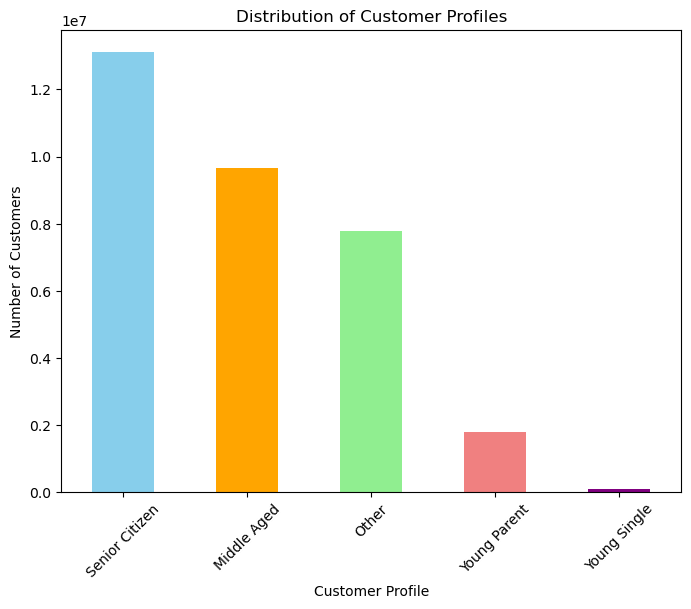

In [25]:
colors = ['skyblue', 'orange', 'lightgreen', 'lightcoral', 'purple']
bar_profile = profile_counts.plot(kind='bar', color=colors, figsize=(8, 6))
bar_profile.set_title('Distribution of Customer Profiles')
bar_profile.set_xlabel('Customer Profile')
bar_profile.set_ylabel('Number of Customers')
bar_profile.set_xticklabels(bar_profile.get_xticklabels(), rotation=45) 

Text(0, 0.5, '')

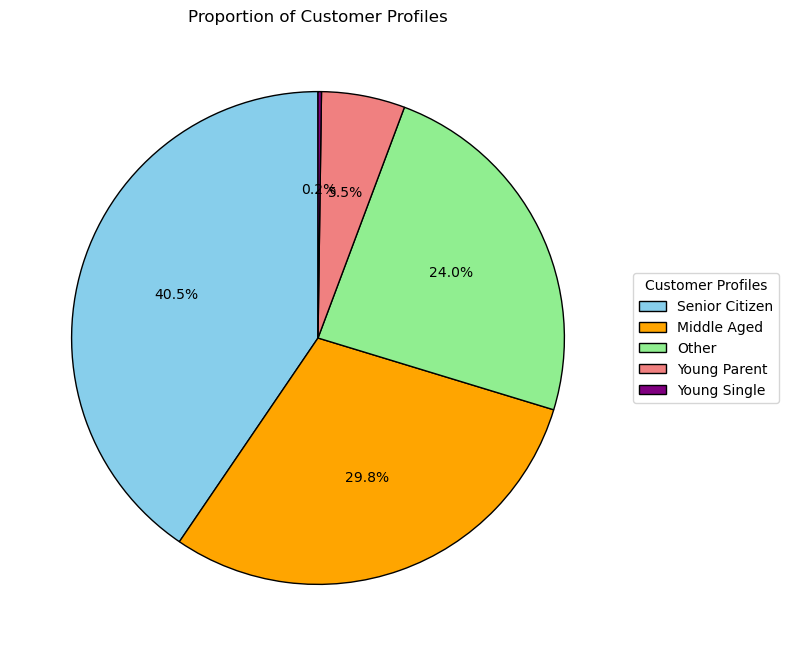

In [26]:
pie_profile = plt.figure(figsize=(8, 8))  
ax = profile_counts.plot(kind='pie', 
                         autopct='%1.1f%%',  
                         startangle=90,  
                         colors=['skyblue', 'orange', 'lightgreen', 'lightcoral', 'purple'], 
                         wedgeprops={'edgecolor': 'black'},  
                         labels=None  
                         )
# Add a custom legend (color key) instead of labels on the chart
plt.legend(profile_counts.index, title='Customer Profiles', loc='center left', bbox_to_anchor=(1, 0.5))

# Title and show the chart
plt.title('Proportion of Customer Profiles')
plt.ylabel('')  

In [27]:
# exporting visuals
bar_profile.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_profile.png'))

In [28]:
pie_profile.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'pie_profile.png'))

## Aggregating Customer Profile

In [30]:
#Map categorical order_frequency_flag to numeric values
freq_mapping = {
    'Frequent customer': 1,
    'Regular customer': 2,
    'Non-frequent customer': 3
}
clean_data['usage_frequency'] = clean_data['order_frequency_flag'].map(freq_mapping)

In [31]:
#Aggregate max, mean, and min for usage_frequency at the customer_profile level
frequency_aggregates = clean_data.groupby('customer_profile').agg({
    'usage_frequency': ['mean', 'min', 'max']
}).reset_index()

In [32]:
#Rename columns for clarity
frequency_aggregates.columns = ['customer_profile', 
                                'usage_frequency_mean', 
                                'usage_frequency_min', 
                                'usage_frequency_max']

In [33]:
frequency_aggregates

,customer_profile,usage_frequency_mean,usage_frequency_min,usage_frequency_max
0,Middle Aged,1.541012,1.0,3.0
1,Other,1.550079,1.0,3.0
2,Senior Citizen,1.543948,1.0,3.0
3,Young Parent,1.543366,1.0,3.0
4,Young Single,1.579897,1.0,3.0


In [34]:
# Map spending_flag to numerical values
spending_mapping = {
    'Low spender': 0,
    'High spender': 1
}
clean_data['spending_flag_numeric'] = clean_data['spending_flag'].map(spending_mapping)

In [35]:
#Aggregate prices and spending_flag_numeric at the customer_profile level
profile_aggregates = clean_data.groupby('customer_profile').agg({
    'prices': ['mean', 'min', 'max'],  
    'spending_flag_numeric': ['mean', 'min', 'max']  
}).reset_index()

In [36]:
# Rename columns for clarity
profile_aggregates.columns = [
    'customer_profile', 
    'expenditure_mean', 'expenditure_min', 'expenditure_max',
    'spending_flag_mean', 'spending_flag_min', 'spending_flag_max'
]

In [37]:
profile_aggregates

,customer_profile,expenditure_mean,expenditure_min,expenditure_max,spending_flag_mean,spending_flag_min,spending_flag_max
0,Middle Aged,12.152302,1.0,99999.0,0.021768,0,1
1,Other,12.836385,1.0,99999.0,0.020813,0,1
2,Senior Citizen,11.953604,1.0,99999.0,0.019313,0,1
3,Young Parent,7.718232,1.0,14900.0,0.004921,0,1
4,Young Single,6.444026,1.0,25.0,0.000000,0,0


In [38]:
# exporting profile aggregates
frequency_aggregates.to_csv(os.path.join(path, '02 Data','Prepared Data', 'frequency_aggregates.csv'))

In [39]:
profile_aggregates.to_csv(os.path.join(path, '02 Data','Prepared Data', 'profile_aggregates.csv'))

## Customer Profile by Region

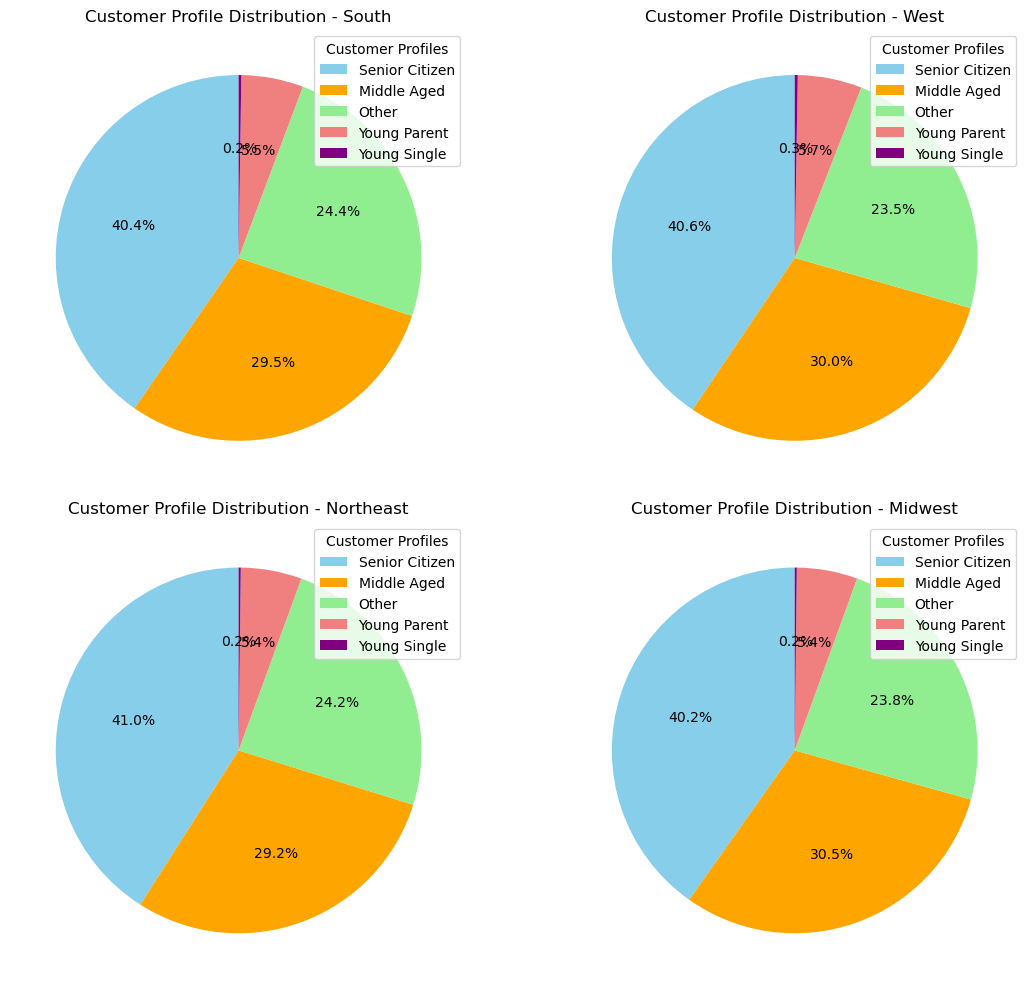

In [41]:
import matplotlib.pyplot as plt

# Assuming 'clean_data' and 'colors' are already defined

# Group the data by region and customer profile
region_customer_profiles = clean_data.groupby('region')['customer_profile'].value_counts()

# Create a 2x2 grid of subplots for the pie charts
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Define regions to loop over (unique regions in the data)
regions = clean_data['region'].unique()

# Loop through each region and plot the pie chart
for i, region in enumerate(regions):
    # Get the customer profile count for the current region
    profile_counts = region_customer_profiles[region]
    
    # Plot the pie chart for this region
    wedges, texts, autotexts = axes[i].pie(
        profile_counts, 
        labels=None,  # No labels beside percentages
        autopct='%1.1f%%',  # Show percentage only
        startangle=90,  # Rotate the chart to start at the top
        colors=colors[:len(profile_counts)]  # Ensure colors match the number of profiles
    )
    
    # Set the title for the chart
    axes[i].set_title(f'Customer Profile Distribution - {region}')
    
    # Add a legend with the customer profiles
    axes[i].legend(wedges, profile_counts.index, title="Customer Profiles", loc="best")

# Adjust layout to prevent overlap
plt.tight_layout()

# Store the figure object in 'profile_region'
profile_region = fig

# Display the figure
plt.show()


Takeaway: Every region in the United States seems to follow the saem general distriubution pattern

In [43]:
# exporting visual
profile_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'profile_reg.png'))

## Customer Profile by Department 

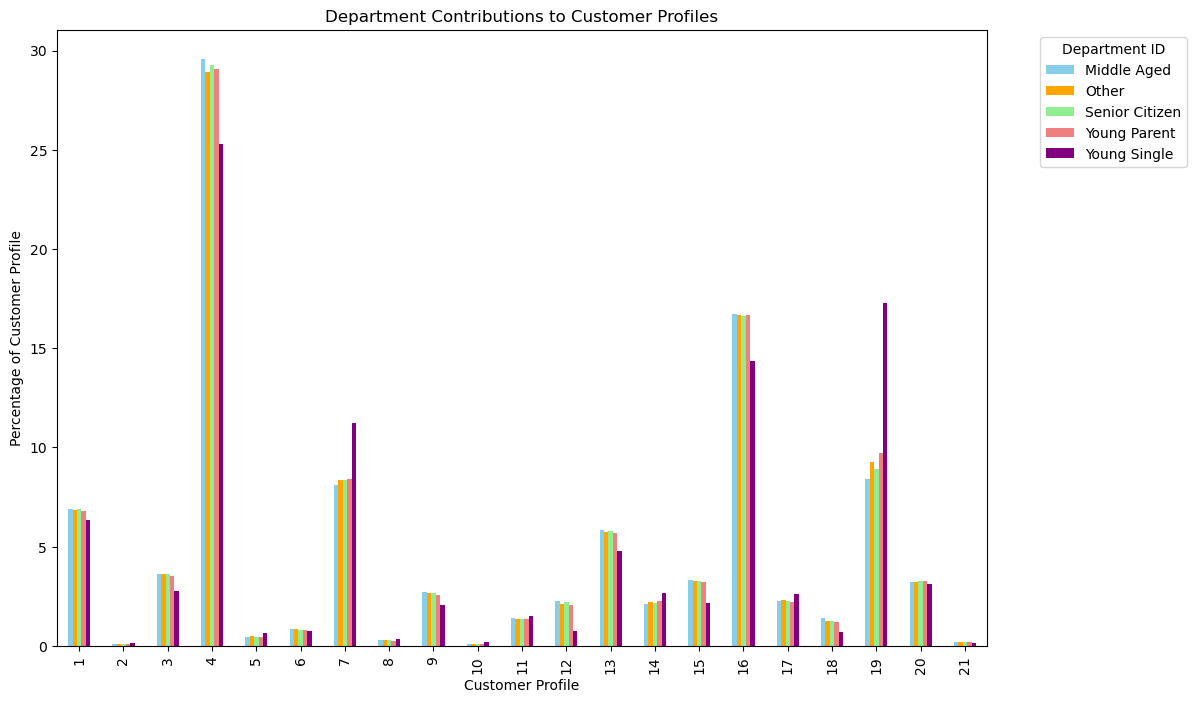

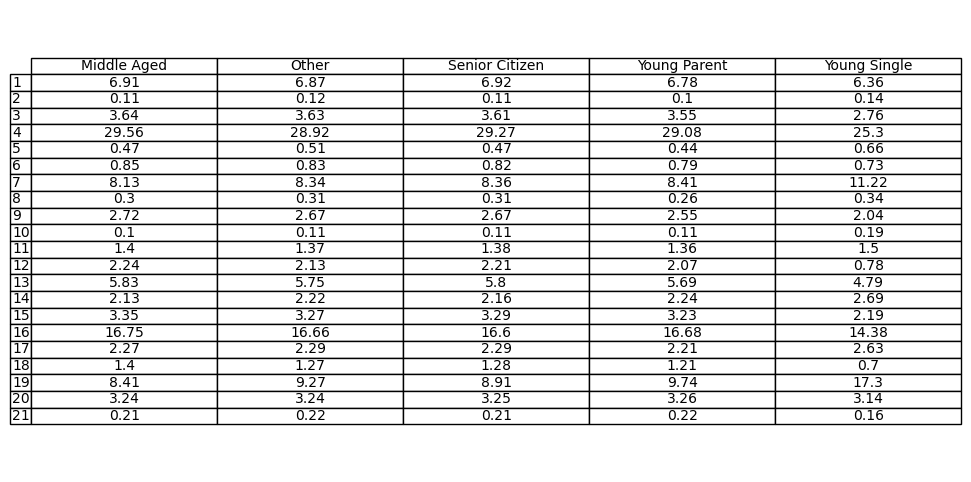

In [66]:
# Group by department_id and customer_profile, then count the occurrences
department_customer_profiles = clean_data.groupby(['department_id', 'customer_profile']).size().unstack(fill_value=0)

# Calculate the percentage for each customer_profile across department_ids
customer_profile_percentages = department_customer_profiles.div(department_customer_profiles.sum(axis=0), axis=1) * 100

# Define custom colors
colors = ['skyblue', 'orange', 'lightgreen', 'lightcoral', 'purple']

# Plot a bar chart for each customer profile, showing how departments contribute
bar_dept_customer, ax_bar = plt.subplots(figsize=(12, 8))  # Name the bar chart as 'bar_dept_customer'

customer_profile_percentages.plot(kind='bar', ax=ax_bar, color=colors, stacked=False)

# Set chart labels and title
ax_bar.set_title('Department Contributions to Customer Profiles')
ax_bar.set_xlabel('Customer Profile')
ax_bar.set_ylabel('Percentage of Customer Profile')
ax_bar.legend(title='Department ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a separate figure for the table of percentages relative to each customer_profile
table_dept_customer, ax_table = plt.subplots(figsize=(12, 6))  # Name the table as 'table_dept_customer'
ax_table.axis('tight')
ax_table.axis('off')

# Add the percentage table, rounded to 2 decimals, to the new figure
ax_table.table(cellText=customer_profile_percentages.round(2).values, 
               colLabels=customer_profile_percentages.columns,
               rowLabels=customer_profile_percentages.index,
               cellLoc='center', loc='center', fontsize=10)

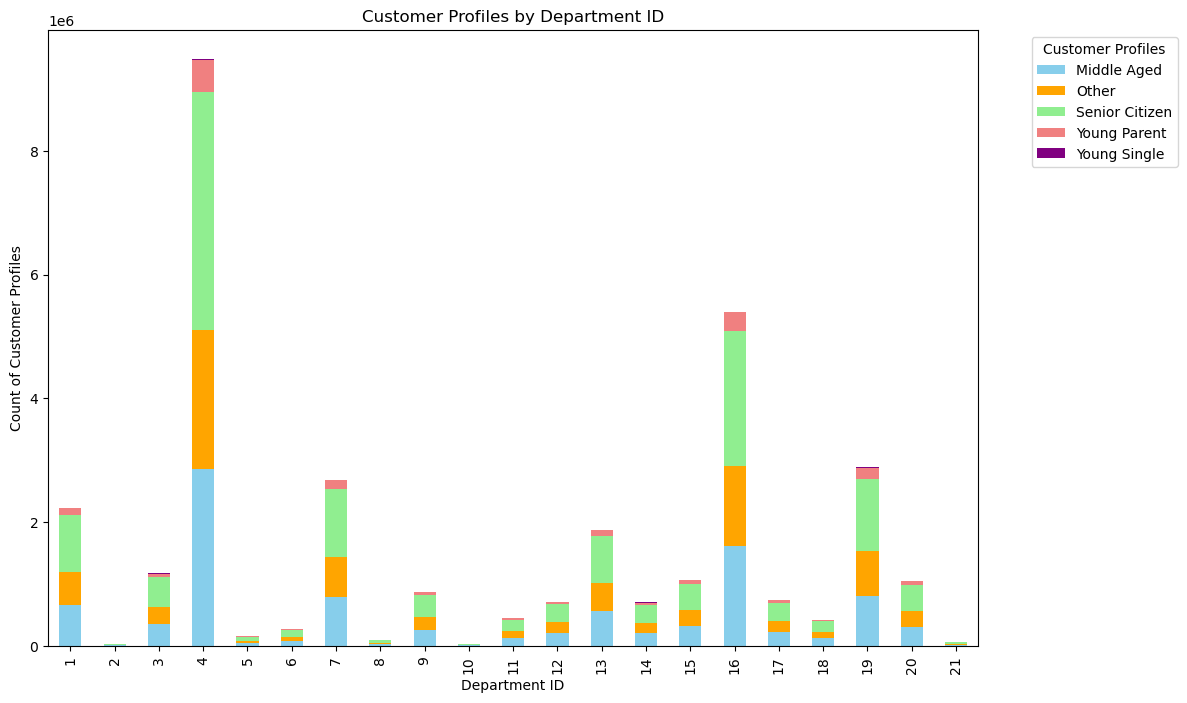

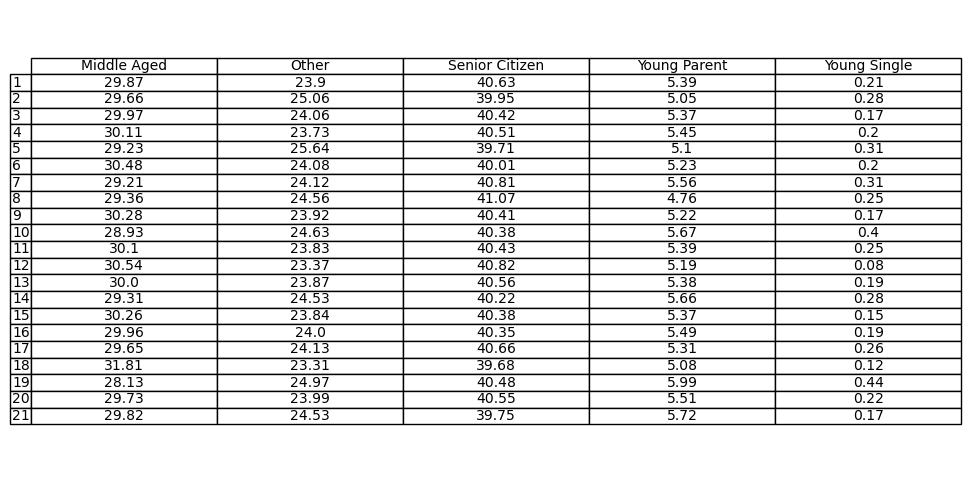

In [70]:
# Group by department_id and customer_profile, then count the occurrences
department_customer_profiles = clean_data.groupby(['department_id', 'customer_profile']).size().unstack(fill_value=0)

# Calculate the percentage for each department (relative to each department)
department_percentages = department_customer_profiles.div(department_customer_profiles.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart with raw counts
fig_bar, ax_bar = plt.subplots(figsize=(12, 8))

department_customer_profiles.plot(kind='bar', stacked=True, ax=ax_bar, color=colors)

# Set chart labels and title
ax_bar.set_title('Customer Profiles by Department ID')
ax_bar.set_xlabel('Department ID')
ax_bar.set_ylabel('Count of Customer Profiles')
ax_bar.legend(title='Customer Profiles', bbox_to_anchor=(1.05, 1), loc='upper left')


# Create a separate figure for the table of percentages relative to each department_id
fig_table, ax_table = plt.subplots(figsize=(12, 6))  # Adjust size as needed
ax_table.axis('tight')
ax_table.axis('off')

# Add the percentage table, rounded to 2 decimals, to the new figure
ax_table.table(cellText=department_percentages.round(2).values, 
              colLabels=department_percentages.columns,
              rowLabels=department_percentages.index,
              cellLoc='center', loc='center', fontsize=10)


# Named variables for saving
bar_customer_dept_id = fig_bar
table_customer_dept_id = fig_table

Takeaway: It seems that the senior citizens make up the largest portion of sales regardless of department id. That being said it isn't that big of amargin to mark anything notable. The only notbale thing from this data is that young singles make up a 

In [77]:
# Saving figures
bar_dept_customer.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_dept_customer.png'))

In [79]:
bar_customer_dept_id.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_customer_dept_id.png'))

In [81]:
table_customer_dept_id.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'table_customer_dept_id.png'))

In [83]:
table_dept_customer.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'table_dept_customer.png'))

In [85]:
# exporting final data set
clean_data.to_csv(os.path.join(path, '02 Data','Prepared Data', 'clean_data.csv'))